### Import libraries

In [1]:
import pandas as pd
import numpy as np
import random
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

from collections import Counter
from wordcloud import WordCloud

### Load contents and their labels from the CSV file

In [2]:
# Read from CSV
pandas_user_guide = pd.read_csv('../data/pandas_user_guide.csv')

In [3]:
# Load contents and their labels
contents = []
labels = []
for index in pandas_user_guide.index:
    contents.append(str(pandas_user_guide.loc[index,'content_text']))
    labels.append(pandas_user_guide.loc[index,'link_text'])

### Clean contents using SpaCy

In [4]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [5]:
# Define a function for text pre-processing
def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    
    # Process the text using spaCy
    doc = nlp(text)
    
    # Create a list of tokens excluding stopwords and punctuation
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    
    # Join tokens back into a single string
    cleaned_text = " ".join(tokens)
    
    return cleaned_text

In [6]:
# Save cleaned content
cleaned_contents = [preprocess_text(content) for content in contents] 

### Gain insights on the data

#### Build a word cloud

In [7]:
# Build word cloud for Indexing and selecting data
words = cleaned_contents[22].split()
word_freq = Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

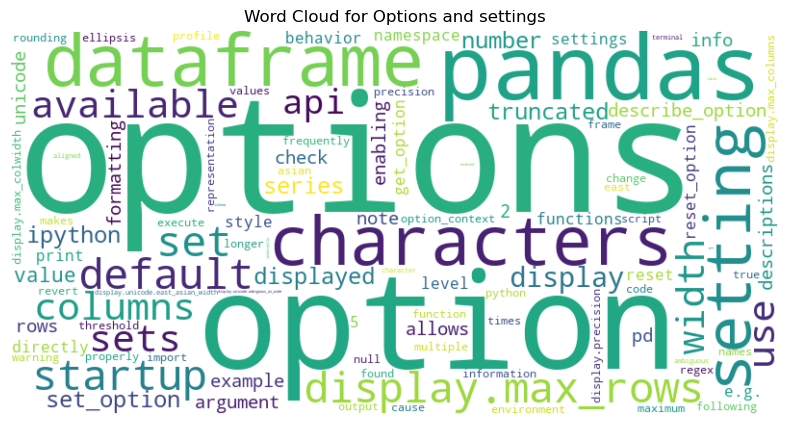

In [8]:
# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for {labels[22]}')
plt.show()

#### Build a word count visualisation

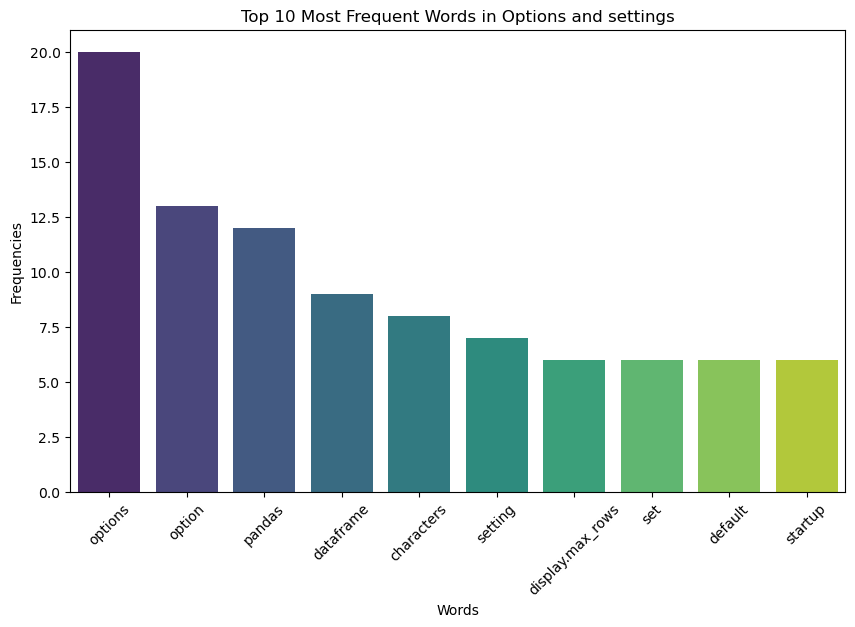

In [9]:
# Get the most common words
common_words = word_freq.most_common(10)

# Separate words and their counts for plotting
words, counts = zip(*common_words)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title(f'Top 10 Most Frequent Words in {labels[22]}')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.xticks(rotation=45)
plt.show()

### Vectorise contents

In [10]:
# Define a custom preprocessor function
def custom_preprocessor(text):
    # The specific repititive string pattern to remove
    large_string_pattern = r'Skip to main content.*?User Guide Essential\.\.\.'
    
    # Remove the large string pattern from the text
    text = re.sub(large_string_pattern, '', text, count = 1)
    
    # Additional preprocessing (e.g., lowercasing, removing punctuation)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

#### Vectorize using Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

In [11]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor)

In [12]:
# Fit and transform the corpus to TF-IDF
X = vectorizer.fit_transform(cleaned_contents)

### Train the models with the contents and their labels, and perform testing

In [13]:
# Function to generate test dataset
def generate_test_dataset(contents, labels, number_of_test_data=100):
    
    test_dataset = []
    
    for _ in range(number_of_test_data):
    
        # Get a random index
        random_index = random.randint(0, len(contents)-1)

        # Load the test content and label
        test_content = contents[random_index]
        test_label = labels[random_index]

        # Tokenize the content text into sentences
        sentences = nltk.sent_tokenize(test_content)

        # Filter sentences with length >= 10
        long_sentences = [sentence for sentence in sentences if len(nltk.word_tokenize(sentence)) >= 10]

        # Choose a random sentence
        random_sentence = random.choice(long_sentences)
    
        # Append the test pair of label and sentence to test_dataset
        test_dataset.append([random_sentence, test_label])
        
    return test_dataset

In [14]:
# Function to get accuracy score on test dataset
def get_accuracy_score_on_test_data(test_dataset, vectorizer, model):
    accuracy_score_ = []
    y_test_ = []
    y_pred_ = []
    
    for item in test_dataset:
        # Prepare test content and label
        X_test = vectorizer.transform([item[0]])
        y_test = [item[1]]
        y_test_.append(y_test)
        
        # Predict and get accuracy score
        y_pred = model.predict(X_test)
        accuracy_score_.append(accuracy_score(y_test, y_pred))
        y_pred_.append(y_pred)
        
    # Generate Classification Report
    classification_report_ = classification_report(y_test_, y_pred_, zero_division=0)
    
    # Return the accuracy scores
    return accuracy_score_, classification_report_

In [15]:
# Generate test dataset of 1000 samples
test_dataset = generate_test_dataset(cleaned_contents, labels, 1000)

#### Logistic Regression model

In [16]:
# Train Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X, labels)

LogisticRegression()

In [17]:
# Get accuracy scores for Logistic Regression model
accuracy_scores_logreg, classification_report_logreg = get_accuracy_score_on_test_data(test_dataset, vectorizer, logreg_model)

In [18]:
print('Classification Report for Logistic Regression' + 
      '\n-----------------------------------------------')
print(classification_report_logreg)

Classification Report for Logistic Regression
-----------------------------------------------
                                      precision    recall  f1-score   support

                10 minutes to pandas       1.00      1.00      1.00        37
                    Categorical data       0.87      0.85      0.86        40
                 Chart visualization       1.00      1.00      1.00        27
                            Cookbook       1.00      1.00      1.00        40
                 Copy-on-Write (CoW)       0.92      1.00      0.96        35
                    Duplicate Labels       1.00      1.00      1.00        25
               Enhancing performance       1.00      0.89      0.94        35
       Essential basic functionality       1.00      0.84      0.91        43
    Frequently Asked Questions (FAQ)       1.00      1.00      1.00        44
       Group by: split-apply-combine       1.00      1.00      1.00        47
       IO tools (text, CSV, HDF5, …)       1.00

#### SVM model

In [19]:
# Train SVM model
svm = SVC()
svm.fit(X, labels)

SVC()

In [20]:
# Get accuracy scores for SVM model
accuracy_scores_svm, classification_report_svm = get_accuracy_score_on_test_data(test_dataset, vectorizer, svm)

In [21]:
print('Classification Report for SVM' + 
      '\n-----------------------------------------------')
print(classification_report_svm)

Classification Report for SVM
-----------------------------------------------
                                      precision    recall  f1-score   support

                10 minutes to pandas       0.88      1.00      0.94        37
                    Categorical data       0.88      0.93      0.90        40
                 Chart visualization       1.00      1.00      1.00        27
                            Cookbook       1.00      1.00      1.00        40
                 Copy-on-Write (CoW)       1.00      1.00      1.00        35
                    Duplicate Labels       1.00      1.00      1.00        25
               Enhancing performance       1.00      1.00      1.00        35
       Essential basic functionality       1.00      1.00      1.00        43
    Frequently Asked Questions (FAQ)       1.00      1.00      1.00        44
       Group by: split-apply-combine       0.96      1.00      0.98        47
       IO tools (text, CSV, HDF5, …)       1.00      0.85      

#### Naive Bayes Model

In [22]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X, labels)

MultinomialNB()

In [23]:
# Get accuracy scores for Naive Bayes model
accuracy_scores_nb, classification_report_nb = get_accuracy_score_on_test_data(test_dataset, vectorizer, nb_classifier)

In [24]:
print('Classification Report for Naive Bayes Classifier' + 
      '\n-----------------------------------------------')
print(classification_report_nb)

Classification Report for Naive Bayes Classifier
-----------------------------------------------
                                      precision    recall  f1-score   support

                10 minutes to pandas       0.88      1.00      0.94        37
                    Categorical data       0.88      0.93      0.90        40
                 Chart visualization       1.00      1.00      1.00        27
                            Cookbook       1.00      1.00      1.00        40
                 Copy-on-Write (CoW)       1.00      1.00      1.00        35
                    Duplicate Labels       1.00      1.00      1.00        25
               Enhancing performance       1.00      1.00      1.00        35
       Essential basic functionality       1.00      1.00      1.00        43
    Frequently Asked Questions (FAQ)       1.00      1.00      1.00        44
       Group by: split-apply-combine       0.96      1.00      0.98        47
       IO tools (text, CSV, HDF5, …)       1

#### Visualise and compare the accuracy scores of different models

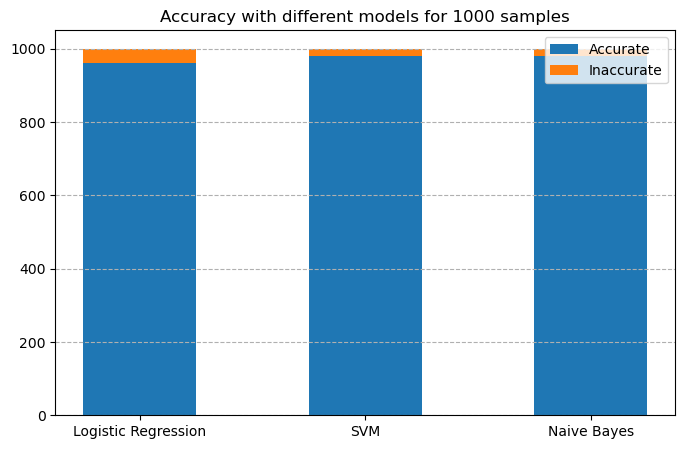

In [25]:
models = (
            'Logistic Regression',
            'SVM',
            'Naive Bayes'
        )

accuracy_score_counts = {
    'Accurate': np.array([
            accuracy_scores_logreg.count(1.0),
            accuracy_scores_svm.count(1.0),
            accuracy_scores_nb.count(1.0)
        ]),
    'Inaccurate': np.array([
            accuracy_scores_logreg.count(0.0),
            accuracy_scores_svm.count(0.0),
            accuracy_scores_nb.count(0.0)
        ])    
}

width = 0.5 # width of the bars
bottom = np.zeros(3)

fig, ax = plt.subplots(figsize=(8,5))

for boolean, accuracy_score_count in accuracy_score_counts.items():
    p = ax.bar(models, accuracy_score_count, width, label=boolean, bottom=bottom)
    bottom += accuracy_score_count

ax.set_title(f"Accuracy with different models for {int(bottom[0])} samples")
ax.legend(loc="upper right")
plt.grid(True, axis='y', linestyle='--')

plt.show()

#### Save the Naive Bayes model and vectorizer on disk

In [26]:
# Save the SVM model to disk
filename = '../saved_models/finalized_svm_model.sav'
joblib.dump(svm, filename)

print("SVM model trained and saved.")

SVM model trained and saved.


In [27]:
# Save the Naive Bayes model to disk
filename = '../saved_models/finalized_nb_model.sav'
joblib.dump(svm, filename)

print("Naive Bayes model trained and saved.")

Naive Bayes model trained and saved.


In [28]:
# Save the vectorizer to disk
filename = '../saved_models/vectorizer.sav'
joblib.dump(vectorizer, filename)

print("Vectorizer trained and saved.")

Vectorizer trained and saved.
